# Method 9 - Rest Ideas After 10

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 10].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

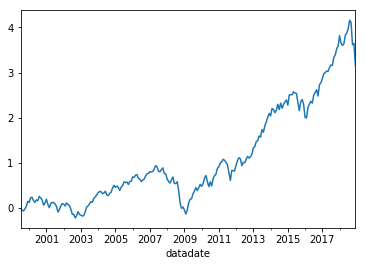

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.147227
2000-12-31   -0.032450
2001-12-31   -0.011337
2002-12-31   -0.220163
2003-12-31    0.506653
2004-12-31    0.166143
2005-12-31    0.059581
2006-12-31    0.108700
2007-12-31   -0.007444
2008-12-31   -0.417255
2009-12-31    0.492137
2010-12-31    0.232249
2011-12-31   -0.030146
2012-12-31    0.200913
2013-12-31    0.414767
2014-12-31    0.096012
2015-12-31   -0.030610
2016-12-31    0.147615
2017-12-31    0.216250
2018-12-31   -0.094846
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2602.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.50e-189
Time:                        20:21:44   Log-Likelihood:                 810.27
No. Observations:                 234   AIC:                            -1611.
Df Residuals:                     229   BIC:                            -1593.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.894      0.000       0.002       0.004
mktrf          1.0261      0.014     71.759      0.000       0.998       1.054
me             0.3070      0.017     18.457      0.000       0.274       0.340
ia             0.0757      0.025      2.994      0.003       0.026       0.125
roe           -0.1519      0.022     -7.019      0.000      -0.195      -0.109
==============================================================================
Omnibus:                       31.900   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.367
Skew:                           0.160   Prob(JB):                     8.42e-44
Kurtosis:                       7.499   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2077.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.29e-178
Time:                        20:21:44   Log-Likelihood:                 810.27
No. Observations:                 234   AIC:                            -1611.
Df Residuals:                     229   BIC:                            -1593.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.016      0.000       0.001       0.004
mktrf          1.0261      0.016     62.809      0.000       0.994       1.058
me             0.3070      0.031      9.819      0.000       0.246       0.368
ia             0.0757      0.044      1.727      0.084      -0.010       0.162
roe           -0.1519      0.035     -4.321      0.000      -0.221      -0.083
==============================================================================
Omnibus:                       31.900   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.367
Skew:                           0.160   Prob(JB):                     8.42e-44
Kurtosis:                       7.499   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2666.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.02e-190
Time:                        20:21:44   Log-Likelihood:                 810.27
No. Observations:                 234   AIC:                            -1611.
Df Residuals:                     229   BIC:                            -1593.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.829      0.000       0.001       0.004
mktrf          1.0261      0.016     62.474      0.000       0.994       1.058
me             0.3070      0.032      9.593      0.000       0.244       0.370
ia             0.0757      0.042      1.792      0.073      -0.007       0.158
roe           -0.1519      0.038     -3.961      0.000      -0.227      -0.077
==============================================================================
Omnibus:                       31.900   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.367
Skew:                           0.160   Prob(JB):                     8.42e-44
Kurtosis:                       7.499   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1660.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.26e-177
Time:                        20:21:44   Log-Likelihood:                 784.93
No. Observations:                 234   AIC:                            -1558.
Df Residuals:                     228   BIC:                            -1537.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.514      0.001       0.001       0.003
mktrf          1.0566      0.016     66.031      0.000       1.025       1.088
smb            0.3460      0.021     16.389      0.000       0.304       0.388
hml            0.0485      0.025      1.947      0.053      -0.001       0.098
rmw           -0.0874      0.028     -3.106      0.002      -0.143      -0.032
cma            0.0400      0.036      1.118      0.265      -0.030       0.111
==============================================================================
Omnibus:                       52.096   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.261
Skew:                           0.706   Prob(JB):                     5.67e-64
Kurtosis:                       8.280   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1453.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.13e-170
Time:                        20:21:44   Log-Likelihood:                 784.93
No. Observations:                 234   AIC:                            -1558.
Df Residuals:                     228   BIC:                            -1537.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.092      0.002       0.001       0.003
mktrf          1.0566      0.016     65.593      0.000       1.025       1.088
smb            0.3460      0.032     10.887      0.000       0.284       0.408
hml            0.0485      0.050      0.973      0.331      -0.049       0.146
rmw           -0.0874      0.036     -2.423      0.015      -0.158      -0.017
cma            0.0400      0.046      0.871      0.384      -0.050       0.130
==============================================================================
Omnibus:                       52.096   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.261
Skew:                           0.706   Prob(JB):                     5.67e-64
Kurtosis:                       8.280   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1863.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.18e-182
Time:                        20:21:44   Log-Likelihood:                 784.93
No. Observations:                 234   AIC:                            -1558.
Df Residuals:                     228   BIC:                            -1537.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.826      0.005       0.001       0.004
mktrf          1.0566      0.016     66.776      0.000       1.026       1.088
smb            0.3460      0.031     11.327      0.000       0.286       0.406
hml            0.0485      0.049      0.993      0.321      -0.047       0.144
rmw           -0.0874      0.040     -2.173      0.030      -0.166      -0.009
cma            0.0400      0.043      0.929      0.353      -0.044       0.124
==============================================================================
Omnibus:                       52.096   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.261
Skew:                           0.706   Prob(JB):                     5.67e-64
Kurtosis:                       8.280   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2161.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.59e-180
Time:                        20:21:44   Log-Likelihood:                 789.02
No. Observations:                 234   AIC:                            -1568.
Df Residuals:                     229   BIC:                            -1551.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.033      0.000       0.001       0.003
mktrf          1.0379      0.014     71.995      0.000       1.010       1.066
smb            0.3816      0.018     21.204      0.000       0.346       0.417
hml            0.0884      0.018      4.946      0.000       0.053       0.124
umd           -0.0773      0.012     -6.590      0.000      -0.100      -0.054
==============================================================================
Omnibus:                       23.260   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.430
Skew:                           0.192   Prob(JB):                     2.31e-20
Kurtosis:                       6.021   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1960.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.49e-176
Time:                        20:21:44   Log-Likelihood:                 789.02
No. Observations:                 234   AIC:                            -1568.
Df Residuals:                     229   BIC:                            -1551.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.108      0.002       0.001       0.004
mktrf          1.0379      0.018     58.239      0.000       1.003       1.073
smb            0.3816      0.023     16.411      0.000       0.336       0.427
hml            0.0884      0.046      1.927      0.054      -0.001       0.178
umd           -0.0773      0.022     -3.577      0.000      -0.120      -0.035
==============================================================================
Omnibus:                       23.260   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.430
Skew:                           0.192   Prob(JB):                     2.31e-20
Kurtosis:                       6.021   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2388.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.23e-185
Time:                        20:21:44   Log-Likelihood:                 789.02
No. Observations:                 234   AIC:                            -1568.
Df Residuals:                     229   BIC:                            -1551.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.878      0.004       0.001       0.004
mktrf          1.0379      0.015     68.816      0.000       1.008       1.068
smb            0.3816      0.024     15.656      0.000       0.334       0.429
hml            0.0884      0.050      1.757      0.079      -0.010       0.187
umd           -0.0773      0.018     -4.333      0.000      -0.112      -0.042
==============================================================================
Omnibus:                       23.260   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.430
Skew:                           0.192   Prob(JB):                     2.31e-20
Kurtosis:                       6.021   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1145.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-91
Time:                        20:21:44   Log-Likelihood:                 394.34
No. Observations:                 120   AIC:                            -778.7
Df Residuals:                     115   BIC:                            -764.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.170      0.000       0.002       0.005
mktrf          1.0227      0.024     42.927      0.000       0.976       1.070
me             0.2763      0.024     11.741      0.000       0.230       0.323
ia             0.1188      0.037      3.223      0.002       0.046       0.192
roe           -0.1749      0.033     -5.363      0.000      -0.240      -0.110
==============================================================================
Omnibus:                       10.700   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.592
Skew:                           0.053   Prob(JB):                     1.02e-06
Kurtosis:                       5.347   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1500.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.36e-98
Time:                        20:21:44   Log-Likelihood:                 394.34
No. Observations:                 120   AIC:                            -778.7
Df Residuals:                     115   BIC:                            -764.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.324      0.001       0.002       0.006
mktrf          1.0227      0.024     42.612      0.000       0.976       1.070
me             0.2763      0.034      8.199      0.000       0.210       0.342
ia             0.1188      0.049      2.411      0.016       0.022       0.215
roe           -0.1749      0.042     -4.152      0.000      -0.258      -0.092
==============================================================================
Omnibus:                       10.700   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.592
Skew:                           0.053   Prob(JB):                     1.02e-06
Kurtosis:                       5.347   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2850.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.40e-114
Time:                        20:21:44   Log-Likelihood:                 394.34
No. Observations:                 120   AIC:                            -778.7
Df Residuals:                     115   BIC:                            -764.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.041      0.002       0.001       0.006
mktrf          1.0227      0.022     46.081      0.000       0.979       1.066
me             0.2763      0.036      7.744      0.000       0.206       0.346
ia             0.1188      0.040      2.933      0.003       0.039       0.198
roe           -0.1749      0.045     -3.918      0.000      -0.262      -0.087
==============================================================================
Omnibus:                       10.700   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.592
Skew:                           0.053   Prob(JB):                     1.02e-06
Kurtosis:                       5.347   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     703.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.66e-84
Time:                        20:21:44   Log-Likelihood:                 379.46
No. Observations:                 120   AIC:                            -746.9
Df Residuals:                     114   BIC:                            -730.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.585      0.000       0.002       0.006
mktrf          1.0964      0.029     38.384      0.000       1.040       1.153
smb            0.3357      0.032     10.377      0.000       0.272       0.400
hml            0.0342      0.040      0.862      0.390      -0.044       0.113
rmw           -0.0658      0.047     -1.407      0.162      -0.158       0.027
cma            0.1005      0.051      1.962      0.052      -0.001       0.202
==============================================================================
Omnibus:                       19.475   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.534
Skew:                           0.468   Prob(JB):                     7.17e-14
Kurtosis:                       6.351   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     928.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.43e-90
Time:                        20:21:44   Log-Likelihood:                 379.46
No. Observations:                 120   AIC:                            -746.9
Df Residuals:                     114   BIC:                            -730.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.124      0.002       0.001       0.006
mktrf          1.0964      0.031     35.089      0.000       1.035       1.158
smb            0.3357      0.046      7.302      0.000       0.246       0.426
hml            0.0342      0.082      0.418      0.676      -0.126       0.195
rmw           -0.0658      0.065     -1.020      0.308      -0.192       0.061
cma            0.1005      0.053      1.908      0.056      -0.003       0.204
==============================================================================
Omnibus:                       19.475   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.534
Skew:                           0.468   Prob(JB):                     7.17e-14
Kurtosis:                       6.351   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1552.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.73e-103
Time:                        20:21:44   Log-Likelihood:                 379.46
No. Observations:                 120   AIC:                            -746.9
Df Residuals:                     114   BIC:                            -730.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      2.881      0.004       0.001       0.006
mktrf          1.0964      0.030     36.109      0.000       1.037       1.156
smb            0.3357      0.046      7.376      0.000       0.247       0.425
hml            0.0342      0.082      0.415      0.678      -0.127       0.196
rmw           -0.0658      0.071     -0.932      0.351      -0.204       0.073
cma            0.1005      0.048      2.079      0.038       0.006       0.195
==============================================================================
Omnibus:                       19.475   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.534
Skew:                           0.468   Prob(JB):                     7.17e-14
Kurtosis:                       6.351   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     936.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-86
Time:                        20:21:44   Log-Likelihood:                 382.59
No. Observations:                 120   AIC:                            -755.2
Df Residuals:                     115   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      4.080      0.000       0.002       0.006
mktrf          1.0484      0.023     45.290      0.000       1.003       1.094
smb            0.3802      0.026     14.424      0.000       0.328       0.432
hml            0.1103      0.026      4.177      0.000       0.058       0.163
umd           -0.0820      0.016     -5.037      0.000      -0.114      -0.050
==============================================================================
Omnibus:                        8.128   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               16.553
Skew:                          -0.012   Prob(JB):                     0.000254
Kurtosis:                       4.819   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1220.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.90e-93
Time:                        20:21:44   Log-Likelihood:                 382.59
No. Observations:                 120   AIC:                            -755.2
Df Residuals:                     115   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.705      0.000       0.002       0.006
mktrf          1.0484      0.028     37.268      0.000       0.993       1.104
smb            0.3802      0.029     13.083      0.000       0.323       0.437
hml            0.1103      0.059      1.856      0.063      -0.006       0.227
umd           -0.0820      0.025     -3.262      0.001      -0.131      -0.033
==============================================================================
Omnibus:                        8.128   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               16.553
Skew:                          -0.012   Prob(JB):                     0.000254
Kurtosis:                       4.819   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1614.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.40e-100
Time:                        20:21:44   Log-Likelihood:                 382.59
No. Observations:                 120   AIC:                            -755.2
Df Residuals:                     115   BIC:                            -741.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.504      0.000       0.002       0.006
mktrf          1.0484      0.022     47.573      0.000       1.005       1.092
smb            0.3802      0.032     12.052      0.000       0.318       0.442
hml            0.1103      0.064      1.732      0.083      -0.015       0.235
umd           -0.0820      0.020     -4.046      0.000      -0.122      -0.042
==============================================================================
Omnibus:                        8.128   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               16.553
Skew:                          -0.012   Prob(JB):                     0.000254
Kurtosis:                       4.819   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2390.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.78e-105
Time:                        20:21:44   Log-Likelihood:                 450.19
No. Observations:                 114   AIC:                            -890.4
Df Residuals:                     109   BIC:                            -876.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      3.326      0.001       0.001       0.003
mktrf          1.0253      0.014     73.120      0.000       0.997       1.053
me             0.3755      0.022     17.344      0.000       0.333       0.418
ia            -0.0552      0.030     -1.837      0.069      -0.115       0.004
roe           -0.1490      0.026     -5.648      0.000      -0.201      -0.097
==============================================================================
Omnibus:                        9.762   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.061
Skew:                          -0.722   Prob(JB):                      0.00653
Kurtosis:                       3.185   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2921.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.47e-110
Time:                        20:21:44   Log-Likelihood:                 450.19
No. Observations:                 114   AIC:                            -890.4
Df Residuals:                     109   BIC:                            -876.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.057      0.000       0.001       0.002
mktrf          1.0253      0.012     84.564      0.000       1.002       1.049
me             0.3755      0.017     22.658      0.000       0.343       0.408
ia            -0.0552      0.028     -1.950      0.051      -0.111       0.000
roe           -0.1490      0.023     -6.518      0.000      -0.194      -0.104
==============================================================================
Omnibus:                        9.762   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.061
Skew:                          -0.722   Prob(JB):                      0.00653
Kurtosis:                       3.185   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3214.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.33e-112
Time:                        20:21:44   Log-Likelihood:                 450.19
No. Observations:                 114   AIC:                            -890.4
Df Residuals:                     109   BIC:                            -876.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.212      0.000       0.001       0.002
mktrf          1.0253      0.012     87.384      0.000       1.002       1.048
me             0.3755      0.016     23.782      0.000       0.345       0.406
ia            -0.0552      0.031     -1.789      0.074      -0.116       0.005
roe           -0.1490      0.022     -6.742      0.000      -0.192      -0.106
==============================================================================
Omnibus:                        9.762   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.061
Skew:                          -0.722   Prob(JB):                      0.00653
Kurtosis:                       3.185   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2195.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.44e-107
Time:                        20:21:44   Log-Likelihood:                 458.51
No. Observations:                 114   AIC:                            -905.0
Df Residuals:                     108   BIC:                            -888.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.415      0.160      -0.000       0.002
mktrf          1.0351      0.012     82.881      0.000       1.010       1.060
smb            0.3496      0.020     17.245      0.000       0.309       0.390
hml            0.0220      0.026      0.853      0.396      -0.029       0.073
rmw           -0.2013      0.032     -6.358      0.000      -0.264      -0.139
cma           -0.0835      0.040     -2.078      0.040      -0.163      -0.004
==============================================================================
Omnibus:                        7.396   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.001
Skew:                          -0.580   Prob(JB):                       0.0302
Kurtosis:                       3.360   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2064.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.01e-105
Time:                        20:21:44   Log-Likelihood:                 458.51
No. Observations:                 114   AIC:                            -905.0
Df Residuals:                     108   BIC:                            -888.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.630      0.103      -0.000       0.001
mktrf          1.0351      0.012     86.383      0.000       1.012       1.059
smb            0.3496      0.018     19.505      0.000       0.314       0.385
hml            0.0220      0.026      0.849      0.396      -0.029       0.073
rmw           -0.2013      0.029     -6.949      0.000      -0.258      -0.145
cma           -0.0835      0.040     -2.086      0.037      -0.162      -0.005
==============================================================================
Omnibus:                        7.396   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.001
Skew:                          -0.580   Prob(JB):                       0.0302
Kurtosis:                       3.360   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2997.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.33e-114
Time:                        20:21:44   Log-Likelihood:                 458.51
No. Observations:                 114   AIC:                            -905.0
Df Residuals:                     108   BIC:                            -888.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.497      0.134      -0.000       0.001
mktrf          1.0351      0.010     99.535      0.000       1.015       1.055
smb            0.3496      0.017     20.902      0.000       0.317       0.382
hml            0.0220      0.027      0.802      0.423      -0.032       0.076
rmw           -0.2013      0.028     -7.233      0.000      -0.256      -0.147
cma           -0.0835      0.043     -1.935      0.053      -0.168       0.001
==============================================================================
Omnibus:                        7.396   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.001
Skew:                          -0.580   Prob(JB):                       0.0302
Kurtosis:                       3.360   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2019.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.30e-101
Time:                        20:21:44   Log-Likelihood:                 440.70
No. Observations:                 114   AIC:                            -871.4
Df Residuals:                     109   BIC:                            -857.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.582      0.562      -0.001       0.001
mktrf          1.0463      0.014     72.450      0.000       1.018       1.075
smb            0.3977      0.023     17.663      0.000       0.353       0.442
hml            0.0167      0.023      0.721      0.473      -0.029       0.063
umd           -0.0574      0.017     -3.281      0.001      -0.092      -0.023
==============================================================================
Omnibus:                        6.545   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.070
Skew:                          -0.486   Prob(JB):                       0.0481
Kurtosis:                       3.577   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1829.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.72e-99
Time:                        20:21:44   Log-Likelihood:                 440.70
No. Observations:                 114   AIC:                            -871.4
Df Residuals:                     109   BIC:                            -857.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.627      0.530      -0.001       0.001
mktrf          1.0463      0.015     68.278      0.000       1.016       1.076
smb            0.3977      0.021     19.299      0.000       0.357       0.438
hml            0.0167      0.026      0.642      0.521      -0.034       0.068
umd           -0.0574      0.016     -3.553      0.000      -0.089      -0.026
==============================================================================
Omnibus:                        6.545   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.070
Skew:                          -0.486   Prob(JB):                       0.0481
Kurtosis:                       3.577   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     4169.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.33e-118
Time:                        20:21:44   Log-Likelihood:                 440.70
No. Observations:                 114   AIC:                            -871.4
Df Residuals:                     109   BIC:                            -857.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.627      0.530      -0.001       0.001
mktrf          1.0463      0.014     74.614      0.000       1.019       1.074
smb            0.3977      0.015     26.243      0.000       0.368       0.427
hml            0.0167      0.025      0.675      0.499      -0.032       0.065
umd           -0.0574      0.015     -3.738      0.000      -0.087      -0.027
==============================================================================
Omnibus:                        6.545   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.070
Skew:                          -0.486   Prob(JB):                       0.0481
Kurtosis:                       3.577   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""